In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
# 기본 경로
image_path = '/content/gdrive/MyDrive/pytest_img/'
# 기본 저장 경로
save_path = '/content/gdrive/MyDrive/pytest_img/_generated_images/'

In [3]:
if not os.path.exists(os.path.join(save_path, "pix2pix/")):
  os.makedirs(os.path.join(os.path.join(save_path, "pix2pix/")))

In [4]:
# tf.io.read_file()은 이미지 파일을 읽어 바이트 타입의 텐서플로 텐서를 반환한다
# tf.io.decode_jpeg()은 바이트 데이터를 입력으로 받아 (높이, 너비, 채널)의 3차원 이미지 텐서로 변환한다
sample_image = tf.io.read_file(image_path+'facades/train/1.jpg')
sample_image = tf.io.decode_jpeg(sample_image) # RGB 변환
print(sample_image.shape)

(256, 512, 3)


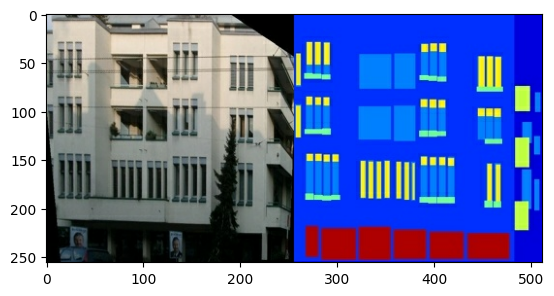

In [5]:
from matplotlib import pyplot as plt
from IPython import display
plt.figure()
plt.imshow(sample_image)

In [6]:
def load(image_file):
  image = tf.io.read_file(image_file) # 이미지를 바이트 타입으로 읽는다
  image = tf.io.decode_jpeg(image) # 바이트 타입의 이미지를 JPEG 형식으로 디코딩. 각 픽셀은 0~255의 값
  # 이미지가 가로 방향의 두 부분으로 나뉘어 있다고 가정하고, 중간 지점에서 분할한다
  w = tf.shape(image)[1] # (256, 512, 3)의 width에 해당하는 512.
  w = w // 2 # 절반값 구함 (256)
  input_image = image[:, w:, :] # 입력 이미지. 오른쪽 절반 추출 (건물 아키텍처 레이블 이미지)
  real_image = image[:, :w, :] # 정답 이미지. 왼쪽 절반 추출 (실제 건물 파사드 이미지)
  # 두 이미지를 float32 타입으로 변환
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image

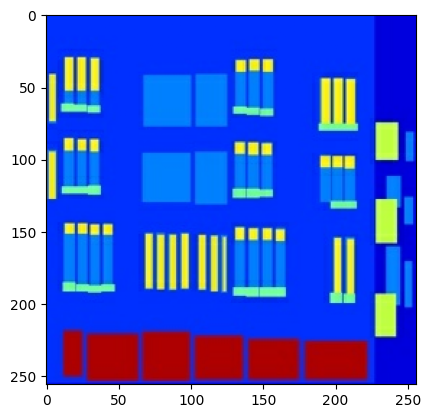

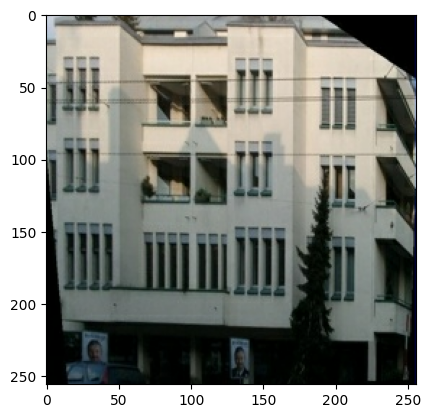

In [7]:
inp, re = load(image_path+"facades/train/1.jpg")

# 255로 나누어 정규화한 뒤 시각화 (0 ~ 1 사이의 값)
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [8]:
BUFFER_SIZE = 400 # train 데이터로 사용되는 이미지의 개수
BATCH_SIZE = 1 # 한 번에 처리되는 이미지의 수. 일반적으로 1을 사용
IMG_HEIGHT = 256 # 변경되는 이미지의 높이
IMG_WIDTH = 256 # 변경되는 이미지의 너비

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0) # 두 이미지를 배치 차원을 추가해 결합 (2, 높이, 너비, 채널)
  cropped_image = tf.image.random_crop( # 랜덤 위치에서 이미지를 자르는 함수
  stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]) # 2개로, 설정된 높이, 설정된 너비, 3 채널로 자름
  return cropped_image[0], cropped_image[1] # 잘린 두 개의 이미지를 return

In [10]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image

In [11]:
def random_jitter(input_image, real_image):
  # 이미지를 자르기 전에 286x286으로 약간 키워 자르기 과정에서 다양한 부분을 포함할 수 있게 한다
  input_image, real_image = resize(input_image, real_image, 286, 286)
  # 랜덤 crop을 수행한다. 이미지는 다시 256x256이 된다
  input_image, real_image = random_crop(input_image, real_image)
  if tf.random.uniform(()) > 0.5: # 50%의 확률로 입력 이미지와 정답 이미지를 좌우 반전한다 (데이터 증강)
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  return input_image, real_image # 입력 이미지와 정답 이미지 return

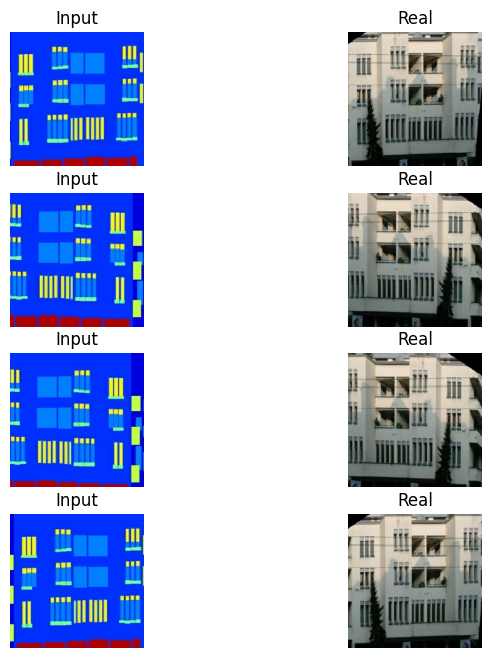

In [12]:
plt.figure(figsize=(8, 8)) # 이미지의 전체 사이즈 설정
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re) # 데이터 증강
  plt.subplot(4, 2, 2*i + 1) # 4x2 서브플롯의 각 행 첫 번째 열에 배치 (홀수)
  plt.imshow(rj_inp / 255.0)
  plt.title("Input")
  plt.axis("off")
  plt.subplot(4, 2, 2*i + 2) # 4x2 서브플롯의 각 행 두 번째 열에 배치 (짝수)
  plt.imshow(rj_re / 255.0)
  plt.title("Real")
  plt.axis("off")
plt.show()

In [13]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [14]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [15]:
train_dataset = tf.data.Dataset.list_files(image_path + "facades/train/*.jpg")
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE) # 데이터셋을 BUFFER_SIZE 만큼씩 무작위로 섞는다
train_dataset = train_dataset.batch(BATCH_SIZE) # 데이터셋을 BATCH_SIZE 만큼씩 배치로 분할한다

In [16]:
test_dataset = tf.data.Dataset.list_files(image_path + "facades/test/*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
def downsample(filters, size, apply_batchnorm=True): # 사용할 필터의 수, 필터의 크기, 배치정규화 여부
  initializer = tf.random_normal_initializer(0., 0.02) # 가중치 초기화. 평균 0, 표준편차 0.02
  result = tf.keras.Sequential() # 모델 생성
  """
  모델에 합성곱 층 추가. 입력 데이터에 strides=2와 padding=‘same’의 2D 합성곱 수행으로 입력 이미지가 절반 크기로 감소됨
  배치정규화로 편향 계산은 무효화되므로
  계산의 단순함을 위해 편향은 사용하지 않음
  """
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization()) # 배치정규화 층 추가
  """
  음수에서도 작은 기울기를 허용하는 LeakyReLU 활성화 함수 사용(기본값 0.3)
  특징을 추출하는 과정에서는 양수뿐 아니라, 음수도 받아들여
  다양한 정보를 학습할 수 있게 한다
  """
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [18]:
# 모델을 수행해서 결과를 확인해본다
# 필터 수 3, 필터 크기 4x4로 합성곱 연산을 수행하는 다운샘플링 모델을 생성한다
down_model = downsample(3, 4)
# 먼저 이미지에 배치 차원을 추가한 후,
# 생성된 모델로 이미지에 다운샘플링을 적용한다
# (256, 256, 3) → (1, 128, 128, 3)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape) # (1, 128, 128, 3) 으로 사이즈가 줄어들었다

(1, 128, 128, 3)


In [19]:
def upsample(filters, size, apply_dropout=False): # 사용할 필터의 수, 필터의 크기, 드롭아웃 적용 여부
  initializer = tf.random_normal_initializer(0., 0.02) # 가중치 초기화. 평균 0, 표준편차 0.02
  result = tf.keras.Sequential() # 모델 생성
  # 모델에 전치 컨볼루션(역합성곱) 층 추가. 입력 데이터에 0을 넣어 데이터를 키운 뒤 합성곱 연산하는 역합성곱을 통해 이미지의 사이즈를 키운다
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization()) # 배치정규화 층 추가

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5)) # 드롭아웃 층 층가
  result.add(tf.keras.layers.ReLU()) # 음수 입력에 0을 출력하는 ReLU 활성화 함수 사용 양수 범위의 픽셀을 강조해야 자연스러운 이미지가 재구성된다
  return result


In [20]:
# 모델을 수행해서 결과를 확인해본다
# 필터 수 3, 필터 크기 4x4으로 합성곱 연산을 수행하는 업샘플링 모델을 생성한다
up_model = upsample(3, 4)
# 앞에서 줄어든 이미지(1, 128, 128, 3)에 업샘플링을 적용한다
up_result = up_model(down_result)
print (up_result.shape) # (1, 256, 256, 3). 사이즈가 2배가 되어 본래 크기가 되었다

(1, 256, 256, 3)


In [21]:
up_model

In [22]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [ # 다운샘플링 스택. 이미지의 차원이 줄어든다
    downsample(64, 4, apply_batchnorm=False), # (batch_size, 128, 128, 64)
    downsample(128, 4), # (batch_size, 64, 64, 128)
    downsample(256, 4), # (batch_size, 32, 32, 256)
    downsample(512, 4), # (batch_size, 16, 16, 512)
    downsample(512, 4), # (batch_size, 8, 8, 512)
    downsample(512, 4), # (batch_size, 4, 4, 512)
    downsample(512, 4), # (batch_size, 2, 2, 512)
    downsample(512, 4), # (batch_size, 1, 1, 512)
  ]
  up_stack = [ # 업샘플링 스택. 이미지의 차원이 커진다
    upsample(512, 4, apply_dropout=True), # (batch_size, 2, 2, 512)
    upsample(512, 4, apply_dropout=True), # (batch_size, 4, 4, 512)
    upsample(512, 4, apply_dropout=True), # (batch_size, 8, 8, 512)
    upsample(512, 4), # (batch_size, 16, 16, 512)
    upsample(256, 4), # (batch_size, 32, 32, 256)
    upsample(128, 4), # (batch_size, 64, 64, 128)
    upsample(64, 4), # (batch_size, 128, 128, 64)
  ]
  initializer = tf.random_normal_initializer(0., 0.02) # 평균 0, 표준편차 0.02
  last = tf.keras.layers.Conv2DTranspose(
      3, 4, # 채널 수가 3이 나오도록 filters의 수를 조정
      strides=2,
      padding='same',
      kernel_initializer=initializer,
      activation='tanh'
  ) # (batch_size, 256, 256, 3)
  x = inputs # 모델의 입력을 x에 할당

  skips = []
  for down in down_stack: # 다운샘플링 스택을 하나씩 실행
    x = down(x) # 각 다운샘플링 레이어에 입력 x를 전달하여 받음
    skips.append(x) # 각 다운샘플링 레이어를 통과한 x를 리스트에 추가

  skips = reversed(skips[:-1]) # 스킵 리스트의 마지막 직전까지만 슬라이싱한 뒤, 모든 요소를 역순으로 정렬

  # 각각의 업샘플링 레이어와 스킵 리스트를 하나씩 순회
  for up, skip in zip(up_stack, skips):
    x = up(x) # 각 업샘플링 레이어에 x를 전달하여 받음
    # 업샘플링된 이미지 x와 현재 스킵 리스트 요소를 합침
    # 고해상도 정보와 저해상도 정보를 결합하는 것
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x) # last 레이어를 통과하여 최종 출력을 얻음
  # 입력과 출력을 지정하여 케라스 모델을 생성하고, return
  return tf.keras.Model(inputs=inputs, outputs=x)

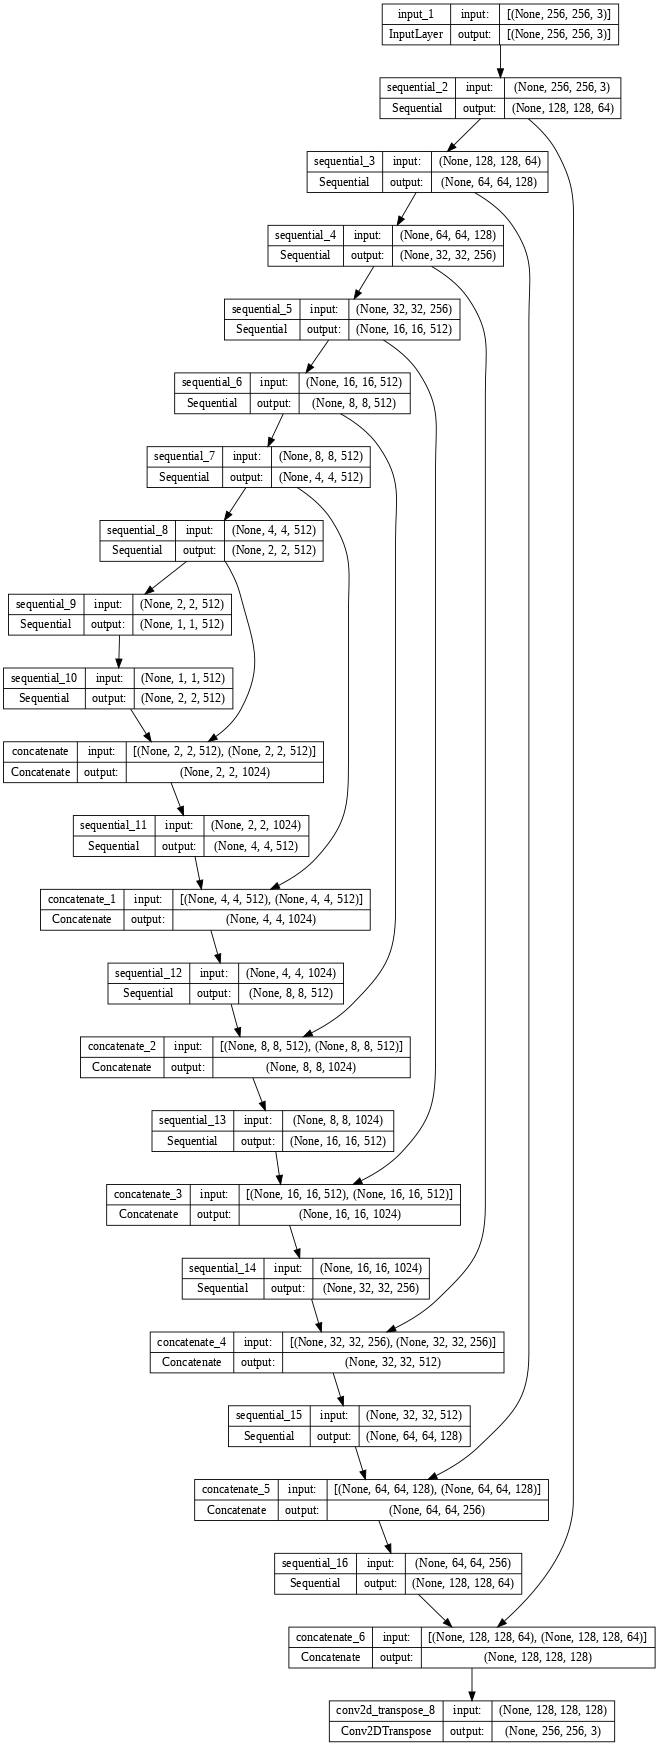

In [23]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

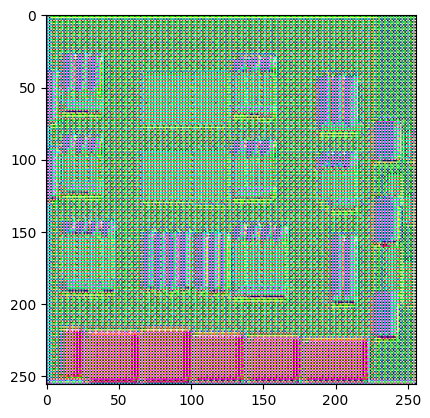

In [24]:
# 입력 이미지에 배치 차원을 추가한 뒤, Functional API 모델인 generator에 넣어 이미지를 생성한다
# outputs는 Generator의 return에 지정된 대로 기본값인 Generator 과정의 최종 출력 텐서 x가 들어간다
# training=False를 수행하면 케라스가 BatchNormalization과 Dropout은 수행하지 않는다
gen_output = generator(inputs=inp[tf.newaxis, ...], training=False)
# 배치 차원을 제외한 (H, W, C) 형태로 이미지를 출력한다
plt.imshow(gen_output[0, ...])

In [25]:
LAMBDA = 100 # 손실함수 가중치
# from_logits=True: 손실함수로 들어오는 입력값이 Sigmoid 함수를 거친 0~1이 아니므로, 내부에서 Sigmoid 변환을 수행하게 한다
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def generator_loss(disc_generated_output, gen_output, target):
  # 판별자를 얼마나 잘 속이는지를 측정. 생성된 이미지가 목푯값 1에 얼마나 가까운지(GAN 손실)를 계산 (낮을수록 가까움)
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # 생성된 이미지가 실제 이미지와 얼마나 가까운지를 측정. 정답 이미지와 생성자 이미지 차이의 절대값(L1 손실)의 평균 (낮을수록 좋음)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  # gan_loss + L1 손실 즉, 가짜를 얼마나 진짜 같이 보였는지로 전체 손실값 계산
  total_gen_loss = gan_loss + (LAMBDA * l1_loss) # 가중치 상수 LAMBDA로 L1 손실의 영향을 조절
  return total_gen_loss, gan_loss, l1_loss # 전체 생성자 손실, GAN 손실, L1 손실을 return

In [27]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02) # 평균 0, 표준편차 0.02로 가중치 초기화
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image') # 원본 입력 이미지
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image') # 진짜 또는 생성된 이미지

  # inp와 tar 이미지를 마지막 차원인 채널 기준으로 병합
  x = tf.keras.layers.concatenate([inp, tar], axis=-1) # (batch_size, 256, 256, channels*2==6)
  # 다운샘플링
  down1 = downsample(64, 4, False)(x) # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (batch_size, 32, 32, 256)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # 제로 패딩 추가. (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)# 합성곱 연산. (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv) # 배치 정규화
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1) # LeakyReLU 활성화 함수 적용
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # 제로 패딩 추가. (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)# (batch_size, 30, 30, 1)
  # 입력(inp, tar)과 출력(last)을 지정하여 케라스 모델을 생성하고, return
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

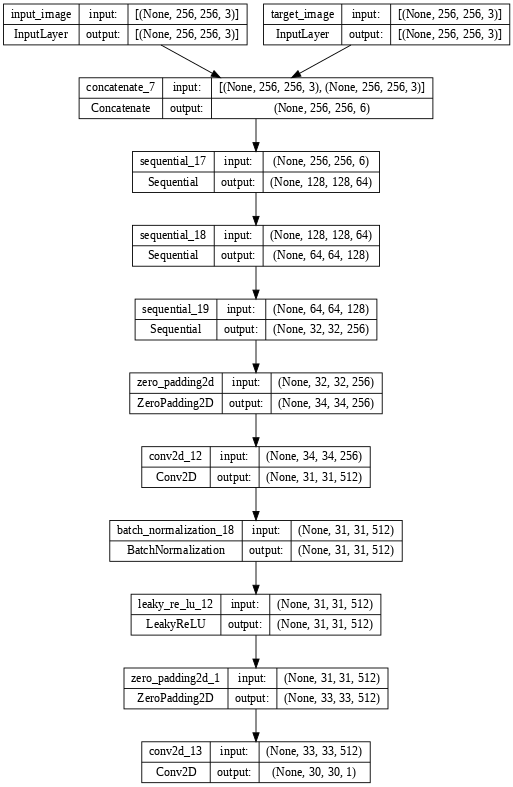

In [28]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

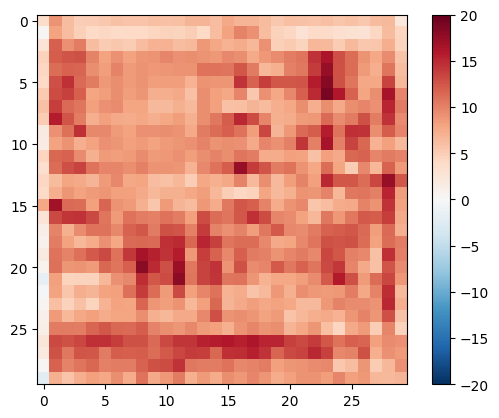

In [29]:
# 입력 이미지에 배치 차원을 추가하여 (1, 256, 256, 3) 형태로 만들어 넣는다
# 생성자 테스트 때 만들어진 생성된 이미지를 넣는다
# training=False 하여 배치정규화와 드롭아웃은 수행하지 않는다
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
# 배치 차원을 제거한 (H, W, C) 형태로 이미지를 출력한다
# 출력 범위를 -20 ~ 20 사이로 나오게 한다. RdBu_r은 양수는 빨간색으로, 음수는 파란색으로 나오게 하는 컬러맵
plt.imshow(disc_out[0, ...], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [30]:
# 판별자가 정답 이미지를 받아 출력한 결과와 판별자가 생성된 가짜 이미지를 받아 출력한 결과 두 개를 받아
# 진짜 이미지가 1에 가까운 정도와 가짜 이미지가 0에 가까운 정도를 각각 구한 뒤, 이를 합쳐 전체 손실값으로 받아들인다
def discriminator_loss(disc_real_output, disc_generated_output):
  # 판별자가 정답 이미지를 진짜로 분류했는지에 대한 손실을 계산 (낮을수록 가까움)
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # 판별자가 가짜 이미지를 가짜로 분류했는지에 대한 손실을 계산 (낮을수록 좋음)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  # real_loss + generated_loss 즉, 진짜를 진짜로, 가짜를 가짜로 얼마나 잘 분류했는지로 전체 판별자 손실을 계산
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss # 전체 판별자 손실을 return


In [31]:
# beta_1은 이전의 기울기를 얼마만큼 반영할 것인지 결정하는 것
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
checkpoint_dir = save_path + 'pix2pix/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")

# 체크포인트 경로 생성
if not os.path.exists(checkpoint_prefix):
  os.makedirs(checkpoint_prefix)

#체크포인트 객체 생성. 생성자의 옵티마이저, 판별자의 옵티마이저, 생성자 모델의 가중치, 판별자 모델의 가중치를 저장
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [33]:
def generate_images(model, test_input, tar): # 모델, 테스트 입력 이미지, 정답 이미지
  prediction = model(test_input, training=True) # 모델로 입력 이미지를 넣어 이미지를 생성. 학습 모드.
  plt.figure(figsize=(15, 15))
  display_list = [test_input[0], tar[0], prediction[0]] # 첫번째 배치의 입력 이미지, 정답 이미지, 생성 이미지 선택
  title = ['Input Image', 'Ground Truth', 'Predicted Image'] # 각 이미지를 설명하는 제목
  for i in range(3):
    plt.subplot(1, 3, i+1) # 1행 3열의 서브플롯의 i+1번째 위치에 이미지 배치
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5) # 픽셀값이 -1~1 사이에 있을 수 있으므로 0~1 사이로 오도록 조정
    plt.axis('off')
  plt.show()

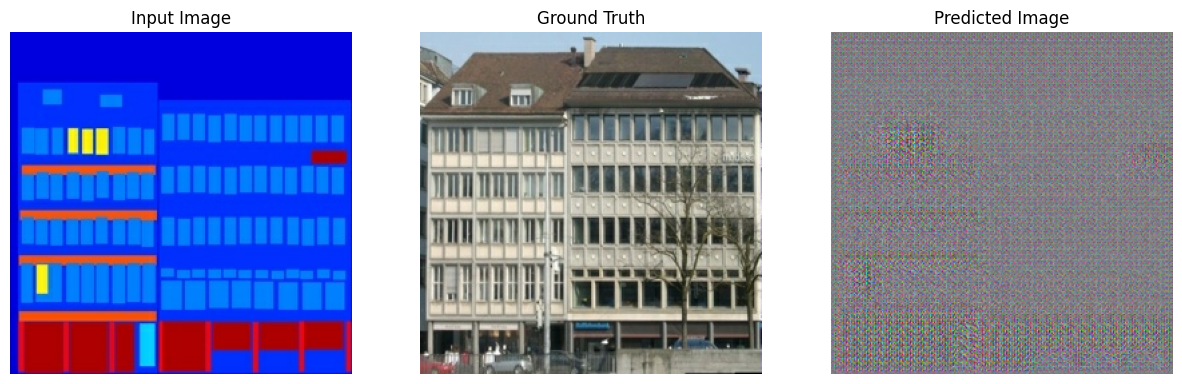

In [34]:
for example_input, example_target in test_dataset.take(1): # 하나의 배치를 가져온다
  generate_images(generator, example_input, example_target)

In [35]:
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # 생성자와 판별자의 그래디언트 추적
    gen_output = generator(input_image, training=True) # 생성자로 입력 이미지로부터 이미지 생성
    disc_real_output = discriminator([input_image, target], training=True) # 입력 이미지와 정답 이미지의 판별자 출력 결과
    disc_generated_output = discriminator([input_image, gen_output], training=True) # 입력과 생성 이미지의 판별자 결과

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    # 판별자의 전체 손실
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # 생성자와 판별자에 대한 그래디언트를 각각 계산
  generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # 그래디언트를 이용하여 생성자와 판별자의 가중치 업데이트
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [36]:
def fit(train_ds, test_ds, steps, save_path): # 훈련 데이터셋, 테스트 데이터셋, 훈련 스텝 수
  example_input, example_target = next(iter(test_ds.take(1))) # 테스트 셋에서 하나의 배치를 가져와 첫 번째 요소를 가져온다
  start = time.time() # 경과 시간 측정용
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0: # 1000 스텝마다 수행
      display.clear_output(wait=True) # 기존 출력 화면 지우기
      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
      start = time.time()
      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step) # 한 스텝의 훈련 수행
    # 훈련 과정 표시
    if (step+1) % 10 == 0: # 10 스텝마다 점을 표시
      print('.', end='', flush=True) # flush=True로 즉시 출력
    # 5000 step마다 모델의 현재 상태를 체크포인트로 저장
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 245.82 sec



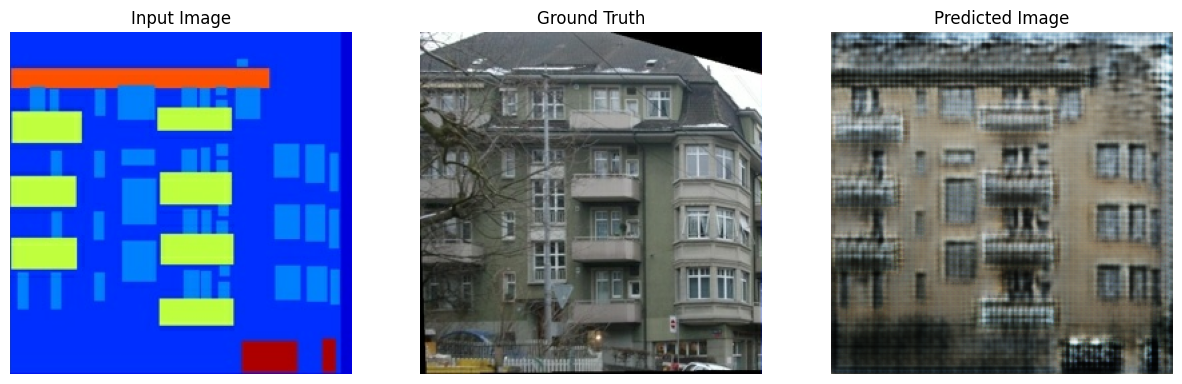

Step: 8k
..............................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=40000, save_path=save_path)